<a href="https://colab.research.google.com/github/Cpt-Shaan/FSRCNN/blob/main/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the necessary libraries and packages.
Setting device to GPU depending on availibility

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
import numpy as np

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Creating a Class for the Dataset to extract raw image data and divide them into High res and Low res images after transforming them to Tensors

In [ ]:
class myDataset(Dataset):

  def __init__(self,root_dir,transform = None):
    self.root_dir = root_dir
    self.transform = transform
    self.img_list = sorted(os.listdir(root_dir))
    self.high_res = self.img_list[::2]
    self.low_res = self.img_list[1::2]
    self.target_size = (321,480)

  def __len__(self):
    return len(self.low_res)

  def __getitem__(self,index):
    high_res_image = Image.open(os.path.join(self.root_dir,self.high_res[index]))
    low_res_image = Image.open(os.path.join(self.root_dir,self.low_res[index]))

    # Resize low-resolution image using bicubic interpolation
    high_res_image = high_res_image.resize(self.target_size,)
    low_res_image = low_res_image.resize(self.target_size, Image.BICUBIC)

    if self.transform:
      high_res_image = self.transform(high_res_image)
      low_res_image = self.transform(low_res_image)
    return torch.tensor(low_res_image), torch.tensor(high_res_image)


#not used
# Custom collate function to handle images with different sizes
def custom_collate_fn(batch):
    low_res_images, high_res_images = zip(*batch)  # Unzip the batch

    # Stack low-res and high-res images as separate batches
    return torch.stack(low_res_images), torch.stack(high_res_images)

Transforming the Image to a tensor

In [ ]:
my_transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = myDataset(root_dir='/content/drive/MyDrive/image_SRF_3',transform = my_transform) # Extracting from the Drive location

Creating the training and testing sets through random splitting

In [ ]:
# Set the total length of the dataset
dataset_size = len(dataset)

# Define the split ratio for training and testing
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = dataset_size - train_size  # The remaining 20% for testing

# Split the dataset into training and testing datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for both train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0 )
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)


Displaying the data from the train set

<ipython-input-2-26922ace09e2>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(low_res_image), torch.tensor(high_res_image)


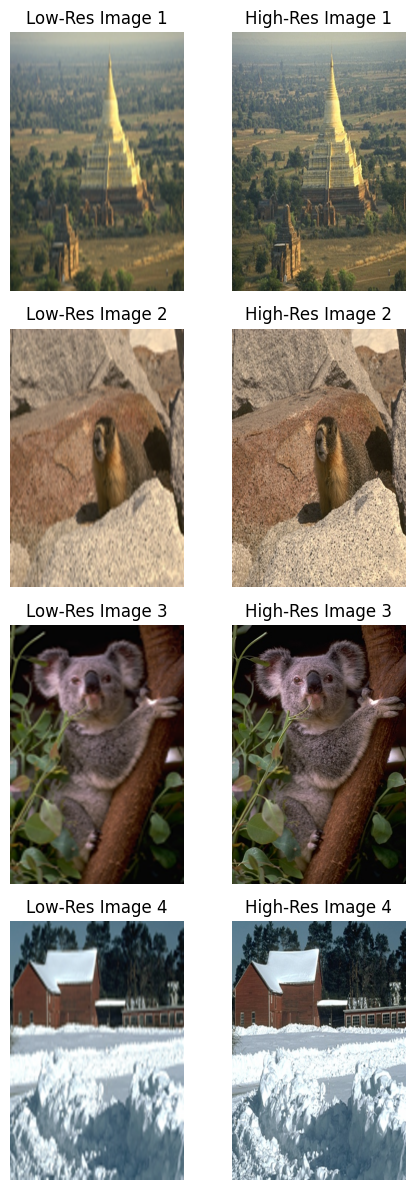

In [ ]:
for low_res_batch, high_res_batch in train_dataloader:
    batch_size = len(high_res_batch)  # Get the batch size (should be 4 based on your DataLoader)

    # Create a figure with 2 columns (high-res and low-res images) and `batch_size` rows
    plt.figure(figsize=(5, batch_size * 3))

    for i in range(batch_size):
        # Plot high-res image in the first column
        plt.subplot(batch_size, 2, 2 * i + 1)  # (nrows, ncols, index)
        plt.imshow(low_res_batch[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(f"Low-Res Image {i+1}")
        plt.axis('off')

        # Plot low-res image in the second column
        plt.subplot(batch_size, 2, 2 * i + 2)  # (nrows, ncols, index)
        plt.imshow(high_res_batch[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(f"High-Res Image {i+1}")
        plt.axis('off')

    # Show the figure with all the images
    plt.tight_layout()
    plt.show()

    # Break after the first batch (you can remove the break to visualize more batches)
    break


Displaying data from the Test set

<ipython-input-2-26922ace09e2>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(low_res_image), torch.tensor(high_res_image)


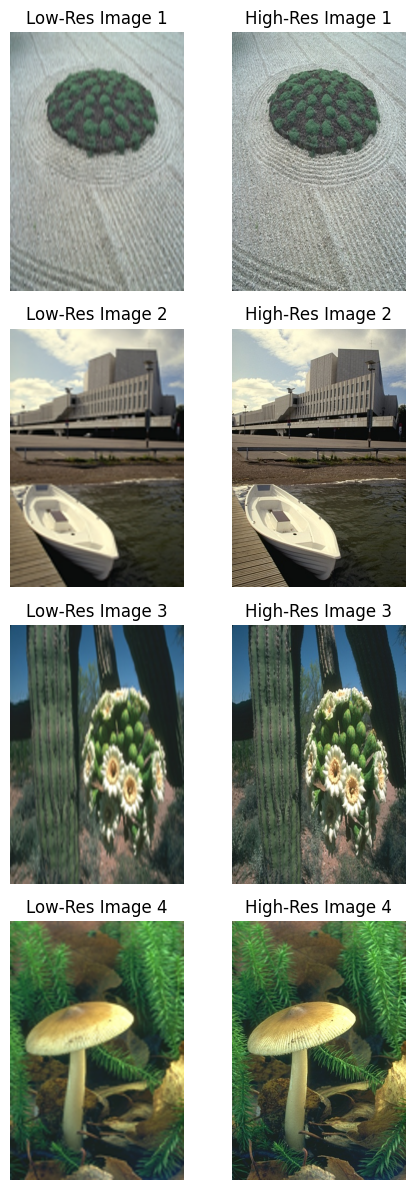

In [ ]:
for low_res_batch, high_res_batch in test_dataloader:
    batch_size = len(high_res_batch)  # Get the batch size (should be 4 based on your DataLoader)

    # Create a figure with 2 columns (high-res and low-res images) and `batch_size` rows
    plt.figure(figsize=(5, batch_size * 3))

    for i in range(batch_size):
        # Plot high-res image in the first column
        plt.subplot(batch_size, 2, 2 * i + 1)  # (nrows, ncols, index)
        plt.imshow(low_res_batch[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(f"Low-Res Image {i+1}")
        plt.axis('off')

        # Plot low-res image in the second column
        plt.subplot(batch_size, 2, 2 * i + 2)  # (nrows, ncols, index)
        plt.imshow(high_res_batch[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(f"High-Res Image {i+1}")
        plt.axis('off')

    # Show the figure with all the images
    plt.tight_layout()
    plt.show()

    # Break after the first batch (you can remove the break to visualize more batches)
    break


Creating the Perceptual Loss class for the VGG-19 pretrained model to extract MSE loss of low-level spatial features upto the 23rd layer (Conv4_3)

In [ ]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, layer='conv4_3'):
        super(VGGPerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        # We will use only up to the layer we want to calculate loss from
        self.feature_extractor = nn.Sequential(*list(vgg.children())[:23])  # conv4_3 layer
        for param in self.feature_extractor.parameters():
            param.requires_grad = False  # Freeze VGG parameters

    def forward(self, original_image, reconstructed_image):
        # Extract features from both images
        original_features = self.feature_extractor(original_image)
        reconstructed_features = self.feature_extractor(reconstructed_image)

        # Compute perceptual loss (L2 loss on the feature maps)
        loss = nn.functional.mse_loss(original_features, reconstructed_features)
        return loss


Creating the Model Architecture for the SRCNN model (9-1-5 architecture)
1. Patch Extraction and Representation (2D conv layer , filter size = 9 , Feature maps = , padding = 4)
2. Non-linear mapping (2D conv layer , filter size = 1 , Feature maps = 32)
3. Reconstruction (2D conv layer , filter size = 9 , Feature maps = 3 , padding = 2)

1st and 2nd layers are followed by a ReLu non-linearity

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()

        # Patch extraction and representation
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)  # 9x9 filters, 64 feature maps
        self.relu1 = nn.ReLU()

        # Non-linear mapping
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1)  # 1x1 filters
        self.relu2 = nn.ReLU()

        # Reconstruction
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)  # 5x5 filters

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)
        return x

Functions for calculating PSNR (Peak Signal to Noise Ratio values)

In [ ]:
# Function to compute PSNR
def compute_psnr(output, target):
    mse = nn.MSELoss()(output, target)
    if mse == 0:
        return float('inf')  # If MSE is 0, return infinity (perfect reconstruction)

    max_pixel_value = 1.0  # Assuming images are normalized to the range [0, 1]
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr

# Example of calculating PSNR after a forward pass
def evaluate_psnr(model, dataloader):
    model.eval()  # Set model to evaluation mode
    total_psnr = 0
    num_images = 0

    with torch.no_grad():  # Disable gradient computation
        for low_res, high_res in dataloader:
            low_res, high_res = low_res.to(device),high_res.to(device)  # low-res input and high-res target images

            # Forward pass through the SRCNN model
            reconstructed = model(low_res)

            # Compute PSNR for the current batch
            psnr = compute_psnr(reconstructed, high_res)
            total_psnr += psnr.item()  # Accumulate PSNR values
            num_images += 1

    # Return the average PSNR over all images
    return total_psnr / num_images


Defining the functions for training the model and simultaneously testing it

In [ ]:
srcnn = SRCNN().to(device)

# Loss functions: Perceptual Loss and MSE Loss
perceptual_loss_model = VGGPerceptualLoss().to(device)
mse_loss = nn.MSELoss()

# Initialize lists to store loss and PSNR values
train_losses = []
train_psnrs = []
test_psnrs = []

# Training loop
def train(srcnn, perceptual_loss_model, train_dataloader,test_dataloader, num_epochs):
    optimizer = torch.optim.Adam(srcnn.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        srcnn.train()  # Set model to training mode
        epoch_loss = 0
        epoch_psnr_train = 0
        num_batches_train = 0

        for data in train_dataloader:
            inputs, targets = data  # low-res input, high-res ground truth

            inputs, targets = inputs.to(device), targets.to(device) # transfer data to the device (cuda)

            optimizer.zero_grad() # Reset gradients to zero to avoid gradient accumulation

            # Forward pass through SRCNN
            outputs = srcnn(inputs)

            # Compute pixel-wise loss (MSE)
            pixel_loss = mse_loss(outputs, targets)

            # Compute perceptual loss
            perceptual_loss = perceptual_loss_model(targets, outputs)

            # Total loss is a combination of pixel loss and perceptual loss
            total_loss = pixel_loss + 0.01 * perceptual_loss  # 0.01 is a weight factor you can tune

            # Backpropagation and optimization
            total_loss.backward()
            optimizer.step()

            # Compute PSNR for the training batch
            psnr = compute_psnr(outputs, targets)
            epoch_psnr_train += psnr.item()
            epoch_loss += total_loss.item()
            num_batches_train += 1

        # Calculate average PSNR for the training set
        avg_loss = epoch_loss / num_batches_train
        avg_psnr_train = epoch_psnr_train / num_batches_train

        # Evaluate PSNR on the test set
        avg_psnr_test = evaluate_psnr(srcnn, test_dataloader)

         # Append metrics to lists for plotting
        train_losses.append(avg_loss)
        train_psnrs.append(avg_psnr_train)
        test_psnrs.append(avg_psnr_test)

        # Log the results
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train PSNR: {avg_psnr_train:.4f}, Test PSNR: {avg_psnr_test:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training the Model

<ipython-input-2-26922ace09e2>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(low_res_image), torch.tensor(high_res_image)


Epoch [1/200], Loss: 0.0693, Train PSNR: 15.1618, Test PSNR: 18.2612
Epoch [2/200], Loss: 0.0310, Train PSNR: 19.0463, Test PSNR: 19.7782
Epoch [3/200], Loss: 0.0239, Train PSNR: 20.9619, Test PSNR: 20.9391
Epoch [4/200], Loss: 0.0197, Train PSNR: 22.5526, Test PSNR: 22.6873
Epoch [5/200], Loss: 0.0178, Train PSNR: 23.4427, Test PSNR: 23.5497
Epoch [6/200], Loss: 0.0165, Train PSNR: 24.1321, Test PSNR: 23.9942
Epoch [7/200], Loss: 0.0155, Train PSNR: 24.7822, Test PSNR: 24.1809
Epoch [8/200], Loss: 0.0149, Train PSNR: 24.8759, Test PSNR: 24.5724
Epoch [9/200], Loss: 0.0141, Train PSNR: 25.2568, Test PSNR: 24.7089
Epoch [10/200], Loss: 0.0140, Train PSNR: 24.8929, Test PSNR: 25.0678
Epoch [11/200], Loss: 0.0136, Train PSNR: 25.1805, Test PSNR: 25.2149
Epoch [12/200], Loss: 0.0130, Train PSNR: 25.6947, Test PSNR: 25.1972
Epoch [13/200], Loss: 0.0128, Train PSNR: 25.7417, Test PSNR: 25.3291
Epoch [14/200], Loss: 0.0126, Train PSNR: 25.8200, Test PSNR: 25.3299
Epoch [15/200], Loss: 0.0124,

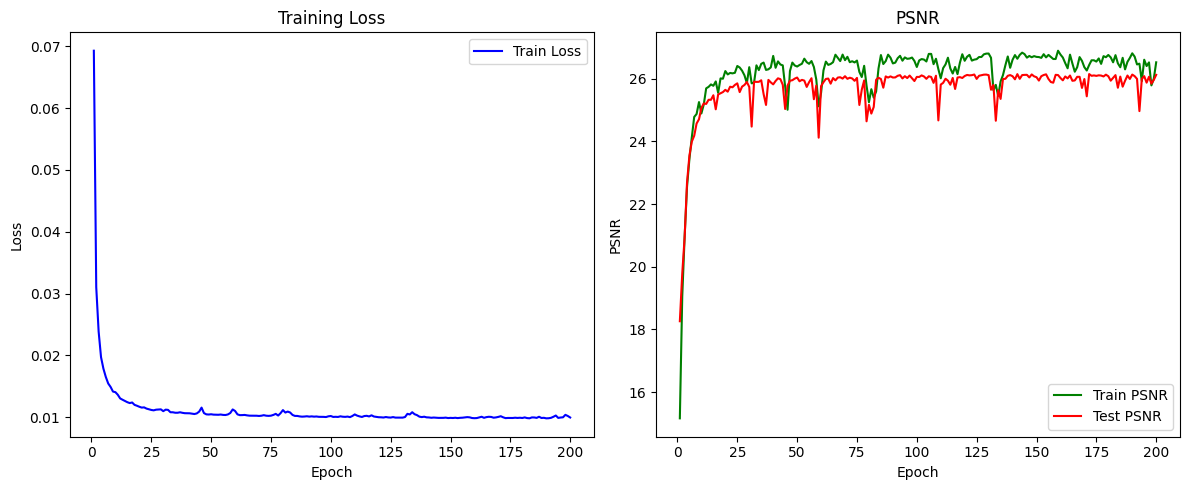

In [ ]:
num_epochs = 200
train(srcnn,perceptual_loss_model,train_dataloader,test_dataloader,num_epochs)

# Plot the loss and PSNR curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot PSNR
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_psnrs, label='Train PSNR', color='green')
plt.plot(range(1, num_epochs + 1), test_psnrs, label='Test PSNR', color='red')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR')
plt.legend()

plt.tight_layout()
plt.show()

Showing the results of the predicted High resolution images

<ipython-input-2-26922ace09e2>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(low_res_image), torch.tensor(high_res_image)


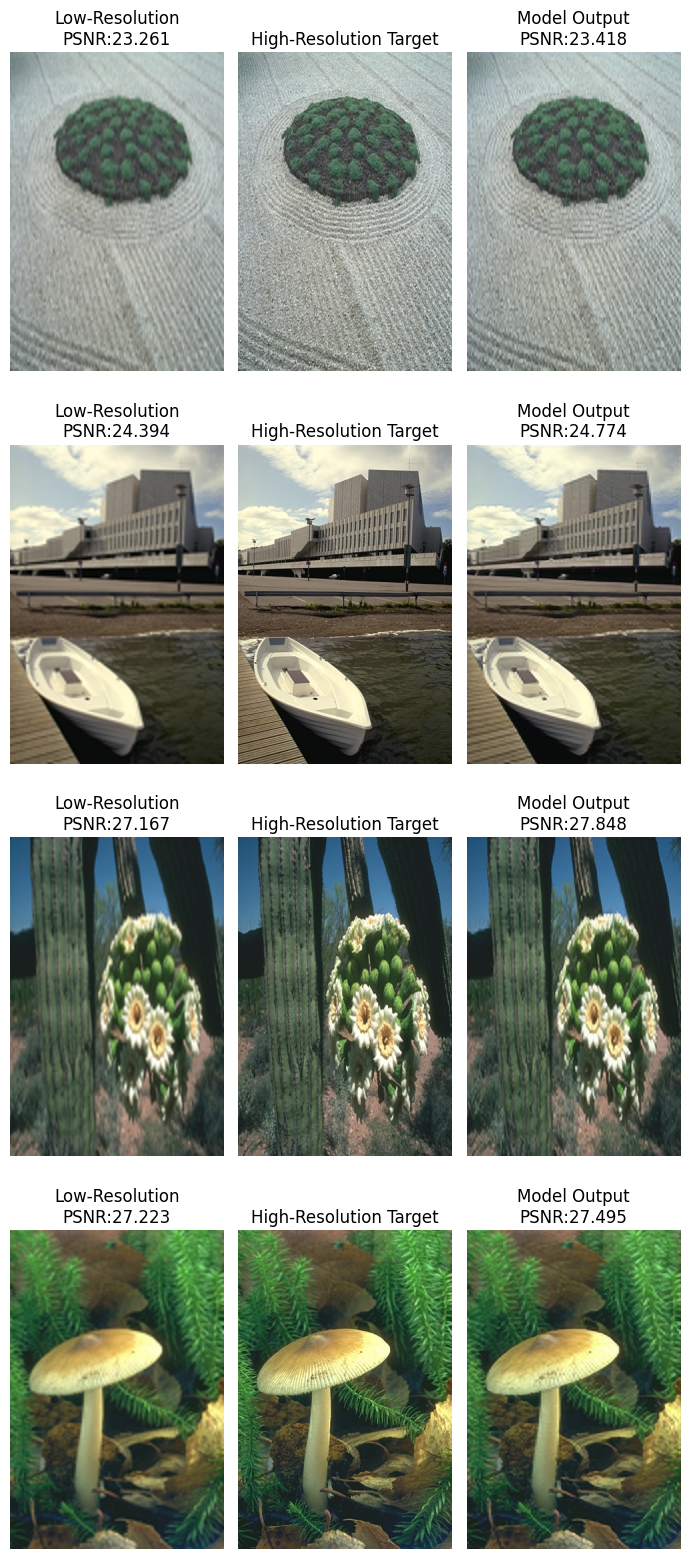

In [ ]:
# Ensure the model is in evaluation mode
srcnn.eval()

with torch.no_grad():
    for low_res_batch, high_res_batch in test_dataloader:
        # Move data to the same device as the model
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        # Get the batch size (should be 4 based on your DataLoader)
        batch_size = len(high_res_batch)

        # Create a figure with 3 columns (low-res, high-res, and reconstructed images) and `batch_size` rows
        fig, ax = plt.subplots(batch_size, 3, figsize=(7, batch_size * 4))

        for i in range(batch_size):
            # Get the current low-res, high-res, and reconstructed image
            low_res_img = low_res_batch[i]
            high_res_img = high_res_batch[i]
            low_res_psnr = compute_psnr(low_res_img,high_res_img)
            reconstruction_psnr = compute_psnr(srcnn(low_res_img.unsqueeze(0)),high_res_img)
            with torch.no_grad():
                reconstructed_img = srcnn(low_res_img.unsqueeze(0).to(device)).squeeze(0).cpu()

            # Convert tensors to numpy arrays and clip values to [0, 1]
            low_res_img = low_res_img.cpu().permute(1, 2, 0).numpy()
            high_res_img = high_res_img.cpu().permute(1, 2, 0).numpy()
            reconstructed_img = reconstructed_img.permute(1, 2, 0).numpy()
            low_res_img = np.clip(low_res_img, 0, 1)
            high_res_img = np.clip(high_res_img, 0, 1)
            reconstructed_img = np.clip(reconstructed_img, 0, 1)

            # Plot images
            ax[i, 0].imshow(low_res_img)
            ax[i, 0].set_title(f'Low-Resolution\nPSNR:{low_res_psnr:.03f}')
            ax[i, 0].axis('off')

            ax[i, 1].imshow(high_res_img)
            ax[i, 1].set_title('High-Resolution Target')
            ax[i, 1].axis('off')

            ax[i, 2].imshow(reconstructed_img)
            ax[i, 2].set_title(f'Model Output\nPSNR:{reconstruction_psnr:.03f}')
            ax[i, 2].axis('off')

        plt.tight_layout()
        plt.show()
        break  # Remove this break to display all batches, keep it to show just one


Saving a checkpoint of the model parameters to use them for different runtimes

In [ ]:
torch.save(srcnn.state_dict(), 'checkpoint.pth')
from google.colab import files
# download checkpoint file
files.download('checkpoint.pth')